**Problem:** przewidzieć, czy klient utrzyma rezerwację hotelową, czy ją anuluje.

**In:** Plik csv ze szczegółowymi danymi dotyczącymi rezerwacji hotelowych pobrany z: https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset
Ostatnia kolumna "booking_status" to kolumna z atrybutem decyzyjnym: czy klient rezerwację anulował czy nie.

**Out:** Predykcja decyzji klienta

# Pobranie potrzebnych bibliotek

In [ ]:
import pandas
from sklearn import preprocessing as prep   #biblioteka potrzebna do utworzenia encodera
from sklearn.model_selection import train_test_split    #biblioteka potrzebna do podzielenia zbioru danych na zbiory treningowy i testowy

#biblioteki potrzebne do utworzenia klasyfikatorów, które chcę zastosować przy przeprowadzaniu testu T&T
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

#biblioteka potrzebna do przeprowadzenia k-krotnej krosowej walidacji
from sklearn.model_selection import cross_val_score 

# Wczytanie danych i preprocessing

In [ ]:
path = "/content/drive/MyDrive/Projekt z Uczenia Maszynowego/Hotel Reservations.csv"

# Wczytujemy dane z CSV do DataFrame
df = pandas.read_csv(path)

# Chcę zobaczyć jakie mam dane - używam metody head i sprawdzam 10 pierwszych wierszy
df.head(10)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
5,INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.00,1,Canceled
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,10,15,Online,0,0,0,107.55,1,Not_Canceled
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,12,26,Online,0,0,0,105.61,1,Not_Canceled
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,7,6,Offline,0,0,0,96.90,1,Not_Canceled
9,INN00010,2,0,0,5,Meal Plan 1,0,Room_Type 4,44,2018,10,18,Online,0,0,0,133.44,3,Not_Canceled


Po sprawdzeniu danych w poprzednim kroku widzę, że:
* nie wszystkie kolumny mają atrybuty liczbowe, część ma atrybuty opisowe (ciągi znaków),
* "type_of_meal_plan" nie zawsze został wybrany przez klienta i jest to opisane
jako "Not Selected" - nie są to wartości puste - po prostu klient nie chce żadnego planu posiłków - zakładam, że chce jeść "na mieście".
* kolumna Booking_ID jest niepotrzebna do uczenia maszynowego, dlatego ją usunę.

In [ ]:
df = df.drop(['Booking_ID'], axis = 1)

In [ ]:
# Sprawdzam liczbę wierszy i kolumn
df.shape

(36275, 18)

In [ ]:
# Wyświetlam informacje o kolumnach: nazwa kolumny, zliczenie danych niepustych (bez brakujących wartości), typ.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

Po sprawdzeniu wiem, że moje dane są pełne (nie ma brakujących wartości). Wiem też jakie są typy danych.

In [ ]:
# Chcę sprawdzić czy w data frame nie ma żadnych danych, które mogą być błędnie wprowadzone.

df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


W danych widzę, że minimalna ilość dorosłych i dzieci to 0. Możliwe, że zamówienie było tylko dla dzieci, lub tylko dla dorosłych. Ale możliwe też, że błędnie wprowadzono dane jako 0.

Zsumuję te dwie kolumny (no_of_adults oraz no_of_children) aby sprawdzić, czy po zsumowaniu będzie jakieś 0. Jeśli nie będzie zera to zakładam, że dane są prawidłowe, a jeśli będzie 0 to dane są błędne i wtedy trzeba je naprawić.

Widzę też, że minimalna ilość zamówionych nocy weekendowych to 0 (no_of_weekend_nights), a także nocy w tygodniu to 0 (no_of_week_nights). Te dane również wymagają podobnego sprawdzenia (również zsumuję te dwie kolumny aby sprawdzić, czy ilość zamówionych nocy wynosi minimum 1).

In [ ]:
sum_customers = df['no_of_adults'].add(df['no_of_children'])
print("minimum sum of customers:", min(sum_customers))

sum_nights = df['no_of_weekend_nights'].add(df['no_of_week_nights'])
print("minimum sum of nights:", min(sum_nights))

minimum sum of customers: 1
minimum sum of nights: 0


Po zsumowaniu kolumn no_of_adults oraz no_of_children widzę, że minimalna ilość klientów to 1, więc zakładam, że te dane są prawidłowe.

Jednakże minimalna ilość nocy to 0. Zakładam, że te dane są błędne. Wiem, że minimum dla średniej ceny za pokój (avg_price_per_room) również wynosi 0. Sprawdzę czy te zera są dla tych wierszy, w których liczba zamówionych nocy wynosi 0. Jeśli tak, to sprawdzę ile jest tych wierszy. Jeśli stosunek ilości wierszy z błędnymi danymi, do ilości wszystkich wierszy będzie niewielki, to usunę te wiersze.

In [ ]:
sum_nights_and_price = sum_nights.add(df['avg_price_per_room'])
count_0 = list(sum_nights_and_price).count(0)
print("minimum sum of nights and price:", min(sum_nights_and_price), ", count rows with minimum sum of nights and price = 0 :",count_0)

minimum sum of nights and price: 0.0 , count rows with minimum sum of nights and price = 0 : 78


In [ ]:
# Jest 78 wierszy, w których są zera zarówno we wprowadzonej ilości nocy, oraz średniej cenie za pokój.
#Obliczam stosunek ilości wierszy z błędnymi danymi, do ilości wierszy w tabeli.

proportion = count_0/len(df)*100
print(f"The proportion of rows with zeros to all rows: {proportion:.1f}%")

The proportion of rows with zeros to all rows: 0.2%


In [ ]:
# Jest niewielki stosunek ilości wierszy z danymi, które uznałam za błędne do ilości wszystych wierszy, dlatego je usuwam.

for row in range(len(df)):
    if df['no_of_weekend_nights'][row] == 0 and df['no_of_week_nights'][row] == 0 and df['avg_price_per_room'][row] == 0:
        df.drop(index=row, inplace = True)

# Po usunięciu wierszy, w których ilość zamówionych nocy jest równa zero w obu kolumnach (no_of_weekend_nights oraz no_of_week_nights) oraz było zero w kolumnie avg_price_per_room, jeszcze raz sprawdzam jaka tym razem jest minimalna ilość zamówionych nocy:
sum_nights = df['no_of_weekend_nights'].add(df['no_of_week_nights'])
print("minimum sum of nights:", min(sum_nights))

minimum sum of nights: 1


Tabela została naprawiona: usunęłam wiersze w których ilość zamówionych nocy jest równa zero w obu kolumnach (no_of_weekend_nights oraz no_of_week_nights) oraz było zero w kolumnie avg_price_per_room.

In [ ]:
# Ponownie sprawdzam metryki dla tabeli
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000,36197.000000
mean,1.845429,0.105313,0.812471,2.209050,0.031052,85.313949,2017.820676,7.423599,15.598005,0.025582,0.023372,0.153466,103.646404,0.619471
std,0.518638,0.402725,0.870767,1.408705,0.173461,85.936931,0.383629,3.068597,8.741400,0.157888,0.368691,1.755786,34.796856,0.786366
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.750000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.600000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.120000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


Nadal są zera w kolumnie avg_price_per_room. Sprawdzę jaki jest stosunek ilości wierszy z zerami w tej kolumnie, do ilości wierszy w tabeli.

In [ ]:
count_price_0 = list(df['avg_price_per_room']).count(0)
print(count_price_0)
proportion_price_0 = count_price_0/len(df)*100
print(f"The proportion of rows with zeros to all rows: {proportion_price_0:.1f}%")

467
The proportion of rows with zeros to all rows: 1.3%


In [ ]:
# Stosunek ilości wierszy z zerami w kolumnie avg_price_per_room do ilości wszystkich wierszy jest niewielki, mogłabym je usunąć, jednak przed podjęciem decyzji sprawdzę jakie występują dane w pozostałych kolumnach dla wierszy w których są zera w kolumnie avg_price_per_room.
for col in df[df['avg_price_per_room'] == 0].columns:
    print(col, df[df['avg_price_per_room'] == 0][col].unique())

no_of_adults [1 2 0 3 4]
no_of_children [0 2 1 3]
no_of_weekend_nights [0 2 1 4]
no_of_week_nights [ 1  2  0  7  3  4 10  5]
type_of_meal_plan ['Meal Plan 1' 'Meal Plan 2' 'Not Selected' 'Meal Plan 3']
required_car_parking_space [0 1]
room_type_reserved ['Room_Type 1' 'Room_Type 2' 'Room_Type 4' 'Room_Type 7' 'Room_Type 6'
 'Room_Type 3' 'Room_Type 5']
lead_time [  2  13   1   4   9   5   3  24   0   8   6  44  12 289  11  32  14  96
  15  38   7  55 224 263  91 122  43  31  10  22 282  39  61  25  64 109
  57  73 192  33  60 320  74  59  80 245 150 210  36 327  71 195 169  81
  56  88  16 271 100 116  75  54 180  28 335  46  45 121  68 256]
arrival_year [2017 2018]
arrival_month [ 9  6  8  5 11  4  2 10  1 12  3  7]
arrival_date [10  1 12 23  7 24 27 13 19 15  6  3 20 21 25 17 31 30 26  8  4  2 28 22
 14 18  5 11  9 16 29]
market_segment_type ['Complementary' 'Online']
repeated_guest [0 1]
no_of_previous_cancellations [0 3 2 4 1]
no_of_previous_bookings_not_canceled [ 0  5  1  3  4  7

Z danych wynika, że tam gdzie są wpisane zera w kolumnie avg_price_per_room	byli zarówno tacy klienci, którzy anulowali rezerwację, jak i tacy, którzy ją utrzymali, były różne typy zamawianych pokoi, rózne typy planów posiłków, różne ilości zamówionych nocy. Dane mogą być ważne dla uczenia maszynowego. Decyduję o ich nieusuwaniu.
Nie będę tych zer poprawiała w żaden sposób (na przykład średnimi), bo trudno stwierdzić jakie miały być ceny. Zakładam, że nie będzie miało to dużego znaczenia dla uczenia maszynowego.

<Axes: >

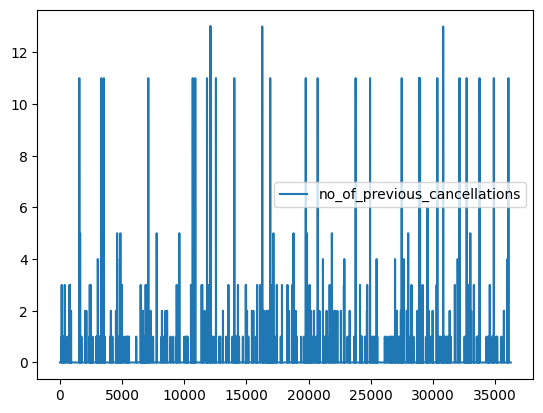

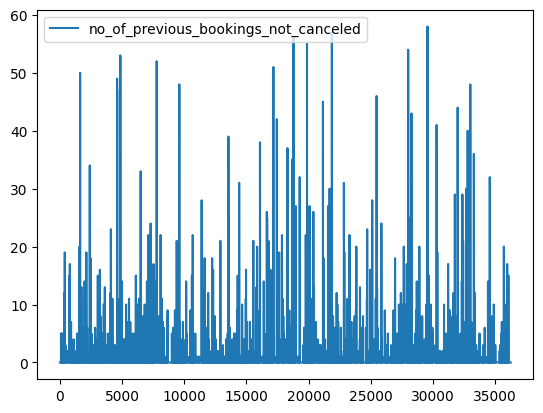

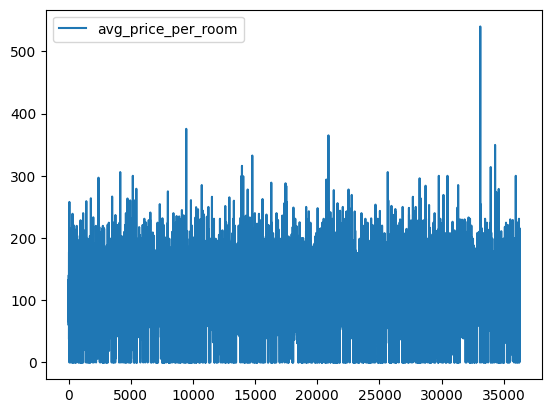

In [ ]:
# Trudno dokonać wszystkich obserwacji patrząc tylko na liczby, więc robię też wykresy (żeby sobie zwizualizować dane) dla kolumn, które wydają się mieć wartości odstające.
import matplotlib.pyplot as plot
%matplotlib inline
df.plot(y=['no_of_previous_cancellations'])
df.plot(y=['no_of_previous_bookings_not_canceled'])
df.plot(y=['avg_price_per_room'])

In [ ]:
# W kolumnie "avg_price_per_room" występuje wartość odstająca względem wszystkich innych. Z wcześniejszych analiz wiem, że ta wartość to wartość maksymalna = 540.
# Zanim zdecyduję co zrobić z wierszem z tą wartością sprawdzę wiersz z tą wartością.

df[df['avg_price_per_room'] == 540]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
33114,2,0,0,1,Meal Plan 1,0,Room_Type 1,35,2018,3,25,Offline,0,0,0,540.0,0,Canceled


In [ ]:
# Nie wygląda na to, żeby ten wiersz wyróżniał się w jakiś sposób od innych (na przykład szczególnym typem zamówionego pokoju, lub szczególnym posiłkiem). Prawdopodobnie cena jest źle wpisana.
# Sprawdzę jeszcze jakie wartości mają wiersze, dla których dane są podobne do danych dla wiersza w którym średnia cena to 540.

filtered_df = df.loc[(df['no_of_adults'] == 2) & (df['no_of_week_nights'] == 1) & (df['type_of_meal_plan'] == 'Meal Plan 1') & (df['room_type_reserved'] == 'Room_Type 1') & (df['arrival_year'] == 2018) & (df['arrival_month'] == 3) & (df['market_segment_type'] == 'Offline')]
for col in filtered_df.columns:
    print(col, filtered_df[col].unique())

no_of_adults [2]
no_of_children [0 1]
no_of_weekend_nights [2 0 1]
no_of_week_nights [1]
type_of_meal_plan ['Meal Plan 1']
required_car_parking_space [0]
room_type_reserved ['Room_Type 1']
lead_time [109 118   4  48  67  21  31  29  11  92  93  49 115  82  17  27 117  30
  23 110 103  40  10  88 113  35  38]
arrival_year [2018]
arrival_month [3]
arrival_date [20  1 23  6 26 19  5 12 31 13 16 11 25]
market_segment_type ['Offline']
repeated_guest [0]
no_of_previous_cancellations [0]
no_of_previous_bookings_not_canceled [0]
avg_price_per_room [ 58.    86.    72.    40.67  89.24  76.16  64.8   63.    87.   100.
  60.    44.67  65.    72.4   66.    55.    43.33  85.    80.    80.24
  75.    38.67 540.  ]
no_of_special_requests [0 1]
booking_status ['Not_Canceled' 'Canceled']


In [ ]:
# Wygląda na to, że średnia cena 540 jest błędnie wpisana. Podejmuję decyzję o usunięciu tego wiersza z tabeli.
df = df.drop(df.loc[df['avg_price_per_room'] == 540].index)

In [ ]:
#W 2018 i 2017 r. luty miał 28 dni. Sprawdzenie czy w tabeli w wierszach, w których jest wpisany luty maksymalny numer dnia to 28. Jeśli więcej niż 28, to zamiana tej liczby na 28 (np. 29 na 28)
filtered_df = df.loc[(df['arrival_month'] == 2)]
print(filtered_df['arrival_date'].unique().max())


29


In [ ]:
#Dla lutego maksymalnie jest wpisanych 29 dni. W 2018 i 2017 r. luty miał 28 dni. Poprawiam w tabeli 29 na 28.
df.loc[(df["arrival_month"] == 2) & (df["arrival_date"] == 29), "arrival_date"] = 28

#W tabeli jest osobna kolumna dla lat, osobna dla miesięcy i osobna dla dni. Połączę te kolumny w jedną tworząc kolumnę z datą. Dzięki temu prawdopodbonie model będzie mógł lepiej znaleźć jakąś ewentualną sezonowość w danych.
##kolumny do połączenia: arrival_year, arrival_month, arrival_date.
df['arrival_date'] = df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str)
df['arrival_date'] = pandas.to_datetime(df['arrival_date'])

# Usunięcie kolumn 'arrival_year', 'arrival_month'
df.drop(['arrival_year', 'arrival_month'], axis=1, inplace=True)
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017-10-02,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018-11-06,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018-02-28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018-05-20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018-04-11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018-08-03,Online,0,0,0,167.80,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018-10-17,Online,0,0,0,90.95,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018-07-01,Online,0,0,0,98.39,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,2018-04-21,Online,0,0,0,94.50,0,Canceled


In [ ]:
# Przerabiam DataFrame na array, bo jest to potrzebne do uczenia (trzeba oddzielić atrybuty warunkowe od decyzji)
data = df.to_numpy()

X = data[:,:-1] # X to dla nas atrybuty warunkowe, bierzemy wszystkie wiersze : i kolumny bez ostatniej :-1
y = data[:,-1] # y to dla nas decyzja. Wiemy, że w tych danych to ostatnia kolumna


# koduję zmienne na numeryczne wartości liczbowe
encoder = prep.LabelEncoder() # Tworzymy sobie enkoder do zamiany typu w danych
for col in range(len(X[0])): # col przyjmie kolejne numery kolumn
    X[:,col]=encoder.fit_transform(X[:,col]) #fit_transform koduje wartości z kolumny.

print(X)

[[2 0 1 ... 0 343 0]
 [2 0 2 ... 0 1912 1]
 [1 0 2 ... 0 238 0]
 ...
 [2 0 2 ... 0 1589 2]
 [2 0 0 ... 0 1435 0]
 [2 0 1 ... 0 3324 0]]


# Przeprowadzenie testu T&T

In [ ]:
#Przygotowuję dane (Dzielimy zbiór danych na trenujący i testowy):
X_tr, X_te, y_tr, y_te = train_test_split(X,y,train_size=0.7, random_state=1)

In [ ]:
#Drzewa decyzyjne. CART.

#Robię słownik z klasyfikatorów.

clf_CART = {
    'treeMaxGini' : tree.DecisionTreeClassifier(),
    'tree3Gini' : tree.DecisionTreeClassifier(max_depth=3), #CART, drzewo decyzyjne, maksymalna głębokość 3, domyślny gini index
    'tree6Gini' : tree.DecisionTreeClassifier(max_depth=6), 
    'tree10Gini' : tree.DecisionTreeClassifier(max_depth=10),
    'tree15Gini' : tree.DecisionTreeClassifier(max_depth=15),
    'tree20Gini' : tree.DecisionTreeClassifier(max_depth=20),
    'tree25Gini' : tree.DecisionTreeClassifier(max_depth=25)   
}

for name in clf_CART:
    clf_CART[name].fit(X_tr, y_tr) # Trenuję algorytm na danych trenujących. Trenujemy sobie clf od name - trenujemy klasyfikator pod tą nazwą czyli tree5 itd
    y_pred = clf_CART[name].predict(X_te)    #dokonujemy predykcji danych testowych tym klasyfikatorem o konkretnej nazwie

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred) #wyświetlamy raport miar: precision, recall, f1-score, dokładność, macro, ważone
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

    treeMaxGini_depth = clf_CART[name].get_depth()   # Sprawdzanie maksymalnej głębokości drzewa dla klasyfikatora treeMaxGini
    print("Max depth of a tree:", treeMaxGini_depth)




**********
treeMaxGini
**********
              precision    recall  f1-score   support

    Canceled       0.80      0.80      0.80      3604
Not_Canceled       0.90      0.90      0.90      7255

    accuracy                           0.87     10859
   macro avg       0.85      0.85      0.85     10859
weighted avg       0.87      0.87      0.87     10859

Max depth of a tree: 39
**********
tree3Gini
**********
              precision    recall  f1-score   support

    Canceled       0.66      0.73      0.69      3604
Not_Canceled       0.86      0.81      0.84      7255

    accuracy                           0.79     10859
   macro avg       0.76      0.77      0.76     10859
weighted avg       0.79      0.79      0.79     10859

Max depth of a tree: 3
**********
tree6Gini
**********
              precision    recall  f1-score   support

    Canceled       0.80      0.70      0.75      3604
Not_Canceled       0.86      0.92      0.89      7255

    accuracy                         

In [ ]:
#Drzewa decyzyjne. C4.5

clf_DT_entropy = {
    'treeMaxEntropy' : tree.DecisionTreeClassifier(criterion='entropy'), #C4,5, drzewo decyzyjne, entropia
    'tree10Entropy' : tree.DecisionTreeClassifier(criterion='entropy', max_depth=10), #C4,5, drzewo decyzyjne, maksymalna głębokość 10, entropia
    'tree15Entropy' : tree.DecisionTreeClassifier(criterion='entropy', max_depth=15), 
    'tree20Entropy' : tree.DecisionTreeClassifier(criterion='entropy', max_depth=20),
}

for name in clf_DT_entropy:
    clf_DT_entropy[name].fit(X_tr, y_tr)
    y_pred = clf_DT_entropy[name].predict(X_te)    

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred)
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

**********
treeMaxEntropy
**********
              precision    recall  f1-score   support

    Canceled       0.80      0.79      0.79      3604
Not_Canceled       0.90      0.90      0.90      7255

    accuracy                           0.86     10859
   macro avg       0.85      0.85      0.85     10859
weighted avg       0.86      0.86      0.86     10859

**********
tree10Entropy
**********
              precision    recall  f1-score   support

    Canceled       0.82      0.78      0.80      3604
Not_Canceled       0.89      0.91      0.90      7255

    accuracy                           0.87     10859
   macro avg       0.85      0.85      0.85     10859
weighted avg       0.87      0.87      0.87     10859

**********
tree15Entropy
**********
              precision    recall  f1-score   support

    Canceled       0.82      0.80      0.81      3604
Not_Canceled       0.90      0.91      0.91      7255

    accuracy                           0.88     10859
   macro avg       

In [ ]:
#Drzewa decyzyjne. Kryterium podziału log_loss

clf_DT_log_loss = {
    'treeMaxLog_loss' : tree.DecisionTreeClassifier(criterion='log_loss'),
    'tree10Log_loss' : tree.DecisionTreeClassifier(criterion='log_loss', max_depth=10),
    'tree15Log_loss' : tree.DecisionTreeClassifier(criterion='log_loss', max_depth=15), 
    'tree20Log_loss' : tree.DecisionTreeClassifier(criterion='log_loss', max_depth=20),
}

for name in clf_DT_log_loss:
    clf_DT_log_loss[name].fit(X_tr, y_tr)
    y_pred = clf_DT_log_loss[name].predict(X_te)

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred)
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

**********
treeMaxLog_loss
**********
              precision    recall  f1-score   support

    Canceled       0.80      0.79      0.80      3604
Not_Canceled       0.90      0.90      0.90      7255

    accuracy                           0.86     10859
   macro avg       0.85      0.85      0.85     10859
weighted avg       0.86      0.86      0.86     10859

**********
tree10Log_loss
**********
              precision    recall  f1-score   support

    Canceled       0.82      0.78      0.80      3604
Not_Canceled       0.89      0.91      0.90      7255

    accuracy                           0.87     10859
   macro avg       0.85      0.85      0.85     10859
weighted avg       0.87      0.87      0.87     10859

**********
tree15Log_loss
**********
              precision    recall  f1-score   support

    Canceled       0.83      0.80      0.81      3604
Not_Canceled       0.90      0.92      0.91      7255

    accuracy                           0.88     10859
   macro avg    

In [ ]:
#Lasy losowe

clf_RF = {
    'RFGini'    : RandomForestClassifier(),                 #random forest, domyślnie ma 100 klasyfikatorów, default=”gini”          
    'RFGini_estm200' : RandomForestClassifier(200),              #dałam 200 klasyfikatorów
    'RF200Gini_estm200_depth15' : RandomForestClassifier(n_estimators=200,max_depth=15),            #dałam 200 klasyfikatorów                           
    'RFEntropy'    : RandomForestClassifier(criterion='entropy'),                   #domyślnie 100 klasyfikatorów, criterion='entropy', max_depth=None czyli maksymalna głębokość drzewa                                 
    'RF200Entropy_estm200_depth15' : RandomForestClassifier(n_estimators=200, criterion='entropy',max_depth=15),          
    'RFlog_loss'    : RandomForestClassifier(criterion='log_loss'),                 #domyślnie 100 klasyfikatorów                               
    'RF200log_loss_estm200_depth15' : RandomForestClassifier(n_estimators=200, criterion='log_loss', max_depth=15),               
}

for name in clf_RF:
    clf_RF[name].fit(X_tr, y_tr)
    y_pred = clf_RF[name].predict(X_te)    

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred)
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

**********
RFGini
**********
              precision    recall  f1-score   support

    Canceled       0.88      0.80      0.84      3604
Not_Canceled       0.91      0.95      0.93      7255

    accuracy                           0.90     10859
   macro avg       0.89      0.87      0.88     10859
weighted avg       0.90      0.90      0.90     10859

**********
RFGini_estm200
**********
              precision    recall  f1-score   support

    Canceled       0.88      0.80      0.84      3604
Not_Canceled       0.91      0.95      0.93      7255

    accuracy                           0.90     10859
   macro avg       0.90      0.87      0.88     10859
weighted avg       0.90      0.90      0.90     10859

**********
RF200Gini_estm200_depth15
**********
              precision    recall  f1-score   support

    Canceled       0.89      0.78      0.83      3604
Not_Canceled       0.90      0.95      0.92      7255

    accuracy                           0.89     10859
   macro avg  

In [ ]:
#boosting z drzewami decyzyjnymi jako bazowym estymatorem

clf_AB_DT = {
    'AB'    : AdaBoostClassifier(),                  #klasyfikator AdaBoost (boosting), estimator=None czyli domyślnie DecisionTreeClassifier z max_depth=1, domyślnie 50 klasyfikatorów, bazowym estymatorem jest DecisionTreeClassifier z max_depth=1
    'AB100' : AdaBoostClassifier(n_estimators=100),  #100 klasyfikatorów, DecisionTreeClassifier z max_depth=1
    'AB200' : AdaBoostClassifier(n_estimators=200),  #200 klasyfikatorów, DecisionTreeClassifier z max_depth=1
    'AB5_50'  : AdaBoostClassifier(DecisionTreeClassifier(max_depth=5)),    #domyślnie 50 klasyfikatorów, DecisionTreeClassifier z max_depth=5
    'AB10_50'  : AdaBoostClassifier(DecisionTreeClassifier(max_depth=10)),
    'AB15_50'  : AdaBoostClassifier(DecisionTreeClassifier(max_depth=15)),
    'AB5_200'  : AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=200), #200 klasyfikatorów, DecisionTreeClassifier z max_depth=5
    'AB10_200'  : AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=200),
    'AB15_200'  : AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators=100),
}

for name in clf_AB_DT:
    clf_AB_DT[name].fit(X_tr, y_tr)
    y_pred = clf_AB_DT[name].predict(X_te) 

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred)
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

**********
AB
**********
              precision    recall  f1-score   support

    Canceled       0.76      0.66      0.71      3604
Not_Canceled       0.84      0.89      0.87      7255

    accuracy                           0.82     10859
   macro avg       0.80      0.78      0.79     10859
weighted avg       0.81      0.82      0.81     10859

**********
AB100
**********
              precision    recall  f1-score   support

    Canceled       0.76      0.68      0.72      3604
Not_Canceled       0.85      0.90      0.87      7255

    accuracy                           0.82     10859
   macro avg       0.80      0.79      0.79     10859
weighted avg       0.82      0.82      0.82     10859

**********
AB200
**********
              precision    recall  f1-score   support

    Canceled       0.77      0.69      0.72      3604
Not_Canceled       0.85      0.90      0.87      7255

    accuracy                           0.83     10859
   macro avg       0.81      0.79      0.80    

In [ ]:
#boosting z lasami losowymi z gini index jako bazowym estymatorem

clf_AB_RF_Gini = AdaBoostClassifier(RandomForestClassifier())
clf_AB_RF_Gini.fit(X_tr, y_tr)
y_pred = clf_AB_RF_Gini.predict(X_te)
report = classification_report(y_te,y_pred)
print(report)


              precision    recall  f1-score   support

    Canceled       0.89      0.78      0.83      3604
Not_Canceled       0.90      0.95      0.92      7255

    accuracy                           0.89     10859
   macro avg       0.89      0.86      0.88     10859
weighted avg       0.89      0.89      0.89     10859



In [ ]:
#boosting z lasami losowymi z entropią i log_loss jako bazowym estymatorem

clf_AB_RF = {
    'AB100RF_entropy'  : AdaBoostClassifier(RandomForestClassifier(criterion='entropy')),
    'AB100RF_log_loss'  : AdaBoostClassifier(RandomForestClassifier(criterion='log_loss')),
}

for name in clf_AB_RF:
    clf_AB_RF[name].fit(X_tr, y_tr) 
    y_pred = clf_AB_RF[name].predict(X_te) 

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred)
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

**********
AB100RF_entropy
**********
              precision    recall  f1-score   support

    Canceled       0.88      0.78      0.83      3604
Not_Canceled       0.90      0.95      0.92      7255

    accuracy                           0.89     10859
   macro avg       0.89      0.86      0.88     10859
weighted avg       0.89      0.89      0.89     10859

**********
AB100RF_log_loss
**********
              precision    recall  f1-score   support

    Canceled       0.88      0.78      0.83      3604
Not_Canceled       0.90      0.95      0.92      7255

    accuracy                           0.89     10859
   macro avg       0.89      0.86      0.88     10859
weighted avg       0.89      0.89      0.89     10859



In [ ]:
#bagging, estimator=None (czyli domyślnie DecisionTreeClassifier) oraz bagging, z przykładu ze strony https://scikit-learn.org/, zespół estymatorów KNeighborsClassifier

clf_BG = {
    'Bg'    : BaggingClassifier(),  #bagging, estimator=None (czyli domyślnie DecisionTreeClassifier), n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0, base_estimator='deprecated'
    'BgNC_05_05'    : BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5), #bagging, z przykładu ze strony https://scikit-learn.org/, zespół estymatorów KNeighborsClassifier, każdy zbudowany na losowych podzbiorach 50% próbek i 50% cech
    'Bg_15_50'    : BaggingClassifier(DecisionTreeClassifier(max_depth=15), n_estimators=50),
    'Bg_20_150'    : BaggingClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=150),
    'Bg_20_250'    : BaggingClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=250),
    'Bg_25_250'    : BaggingClassifier(DecisionTreeClassifier(max_depth=25), n_estimators=250),
}

for name in clf_BG:
    clf_BG[name].fit(X_tr, y_tr)
    y_pred = clf_BG[name].predict(X_te)

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred)
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

**********
Bg
**********
              precision    recall  f1-score   support

    Canceled       0.84      0.83      0.83      3604
Not_Canceled       0.91      0.92      0.92      7255

    accuracy                           0.89     10859
   macro avg       0.88      0.87      0.87     10859
weighted avg       0.89      0.89      0.89     10859

**********
BgNC_05_05
**********
              precision    recall  f1-score   support

    Canceled       0.86      0.55      0.67      3604
Not_Canceled       0.81      0.95      0.88      7255

    accuracy                           0.82     10859
   macro avg       0.84      0.75      0.78     10859
weighted avg       0.83      0.82      0.81     10859

**********
Bg_15_50
**********
              precision    recall  f1-score   support

    Canceled       0.87      0.81      0.84      3604
Not_Canceled       0.91      0.94      0.92      7255

    accuracy                           0.89     10859
   macro avg       0.89      0.87      

In [ ]:
#bagging, estymator to lasy losowe

clf_BG = {
    'Bg_RFGini_150'    : BaggingClassifier(RandomForestClassifier(max_depth=15)),
    'Bg_RFEntropy_150'    : BaggingClassifier(RandomForestClassifier(criterion='entropy', max_depth=15)),
    'Bg_RFLog_loss_150'    : BaggingClassifier(RandomForestClassifier(criterion='log_loss',max_depth=15)),
}

for name in clf_BG:
    clf_BG[name].fit(X_tr, y_tr)
    y_pred = clf_BG[name].predict(X_te)

# Teraz przechodzę do walidacji mojego algorytmu (ocenę jego jakości).
    report = classification_report(y_te,y_pred)
    print("*"*10)
    print(name)
    print("*"*10)
    print(report)

**********
Bg_RFGini_150
**********
              precision    recall  f1-score   support

    Canceled       0.88      0.77      0.82      3604
Not_Canceled       0.89      0.95      0.92      7255

    accuracy                           0.89     10859
   macro avg       0.89      0.86      0.87     10859
weighted avg       0.89      0.89      0.89     10859

**********
Bg_RFEntropy_150
**********
              precision    recall  f1-score   support

    Canceled       0.88      0.77      0.82      3604
Not_Canceled       0.89      0.95      0.92      7255

    accuracy                           0.89     10859
   macro avg       0.89      0.86      0.87     10859
weighted avg       0.89      0.89      0.89     10859

**********
Bg_RFLog_loss_150
**********
              precision    recall  f1-score   support

    Canceled       0.88      0.77      0.82      3604
Not_Canceled       0.89      0.95      0.92      7255

    accuracy                           0.89     10859
   macro avg 

Najsłabsze wyniki są dla:
* 'BgNC_05_05'    : BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5) czyli bagging, z przykładu ze strony https://scikit-learn.org/, zespół estymatorów KNeighborsClassifier, każdy zbudowany na losowych podzbiorach 50% próbek i 50% cech,
* 'AB'    : AdaBoostClassifier() czyli klasyfikator AdaBoost (boosting), estimator=None czyli domyślnie DecisionTreeClassifier z max_depth=1, domyślnie 50 klasyfikatorów,
* 'AB100' : AdaBoostClassifier(n_estimators=100),  #100 klasyfikatorów, DecisionTreeClassifier z max_depth=1,
* 'AB200' : AdaBoostClassifier(n_estimators=200),  #200 klasyfikatorów, DecisionTreeClassifier z max_depth=1,
* 'tree3Gini' : tree.DecisionTreeClassifier(max_depth=3), #CART, drzewo decyzyjne, maksymalna głębokość 3, domyślny gini indeks,
* 'tree6Gini' : tree.DecisionTreeClassifier(max_depth=6).

Pozostałe wyniki są zbliżone i w miarę skuteczne w przewidywaniu anulowania rezerwacji hotelowej przez klienta.

Chcę wiedzieć czy klient anuluje czy utrzyma rezerwację. Zakładam, że firma będzie chciała wiedzieć, którzy klienci są wysokiego ryzyka (czyli jest duże prawdopodobieństwo, że anulują rezerwację), aby zaoferować im dodatkową usługę w celu podtrzymania rezerwacji. Jednocześnie firma nie chce podejmować tych kosztownych działań wobec klientów, którzy i tak nie anulowaliby rezerwacji. W takim przypadku precision będzie ważniejsze niż recall.

Najlepsze wyniki dla takiego problemu dały następujące klasyfikatory:
* 'Bg_20_150'    : BaggingClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=150),
* 'Bg_20_250'    : BaggingClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=250),
* 'RFEntropy'    : RandomForestClassifier(criterion='entropy'), 
* 'RFGini'    : RandomForestClassifier(),random forest, domyślnie ma 100 klasyfikatorów, default=”gini”          
* 'RFGini_estm200' : RandomForestClassifier(200)

(dla canceled: precision około 88, recall około 80, dla not canceled precision około 91, recall około 94, dokładność około 90)


In [ ]:
# Wybrałam lasy losowe, criterion='gini', bo ma jedne z najlepszych wyników, więc na nim trenuję klasyfikator. Potem możemy go już używać.

clf = RandomForestClassifier()
clf.fit(X,y) # trenujemy na całości

RandomForestClassifier()

# Przeprowadzenie testu CV

In [ ]:
#K-krotna krosowa walidacja. Dzieli zbiór danych na k zbiorów i k razy dokonuje nauki, każdy obiekt k-1 razy służy do uczenia i do predykcji. Sama w sobie trenuje i testuje.

clf = RandomForestClassifier()  #robię klasyfikator: lasy losowe - wybrałam ten, bo w T&T dawał jedne z najlepszych wyników dla mojego problemu

#krosowa walidacja musi od razu dawać nam wyniki
result = cross_val_score(clf,X,y, cv = 10)  #zbiór danych wejściowych jest dzielony na 10 części (domyślnie jest 4)

print(result, sum(result)/len(result))  #wyświetalam też średnią dokładność tej metody

[0.90856354 0.90773481 0.90745856 0.8980663  0.90055249 0.9019337
 0.90522244 0.89693285 0.89914341 0.90135397] 0.9026962058747646


In [ ]:
#Średnia wyników walidacji krzyżowej to około 0,9 czyli czyli w około 90% przypadków przewidywania modelu są poprawne. Wyniki są dość wysokie i dobre.